# Key papers

**TOPICS OF INTEREST** - from the meeting in January

* inflammation aging chronic (2004) - 13k papers
* genome editing / manipulation, CRISPR - 13k papers
* induced stem cells - 73k papers - 3h for calculating co-citations
* single-cell sequencing (2012) - 3k papers
* ATAC-seq (2015) - 276 papers
* immunomodulation cancer - 71k papers
* Telomere Theories of Aging - ??
* mTOR pathway - 14255
* autophagy - ??
* Calorie restriction - 3933

Complement Factor H + Age-Related Mascular Degeneration - investigate

A file with citation stats is required to run several cells of this notebook successfully.
The file can be obtained with the following commands if user has access to `pubmed` database (use crawler).

1. Run `psql`.
2. Run following commands in the `psql` prompt:
    * `\f ','`
    * `\a`
    * `\t`
    * `\o '/path/to/the/file'`
    * `SELECT C.pmid_cited AS pmid, P.year, COUNT(1) AS count`
    * `FROM Citations C`
    * `JOIN Publications P`
    * `ON C.pmid_citing = P.pmid`
    * `GROUP BY C.pmid_cited, P.year;`
    * `\o`
3. Store `/path/to/the/file` in the `CITATION_STATS_FILE` variable in the following cell.

**Issues**:

1. Some information in tooltips with long titles may occur out of plot bounds.
2. How should I place articles with the same year? (currently y-axis position is random in [0,1]...)
3. Some research on clustering algorithms is needed! (also `networkx.algorithms.community`)

**Functions**:

1. Subtopic Analysis based on co-citation graph clustering
2. Top Cited Papers detection (overall and for certain year)
3. Citation Dynamics for a certain article

## Search Terms

In [1]:
SEARCH_TERMS = ['human', 'aging', 'epigenetic']

In [2]:
from importlib import reload
import logging
reload(logging)

import re
import gc
import ipywidgets as widgets
import networkx as nx
import numpy as np
import pandas as pd
import psycopg2 as pg_driver

from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource, LabelSet, OpenURL, TapTool, CustomJS
from bokeh.plotting import figure, show, output_notebook
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

from Bio import Entrez

Entrez.email = 'nikolay.kapralov@gmail.com'
PUBMED_ARTICLE_BASE_URL = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
output_notebook()

Loading BokehJS ...

2019-05-02 14:53:54,357 DEBUG: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
class KeyPaperAnalyzer:       
    def __init__(self):
        self.conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
        self.cursor = self.conn.cursor()
        
    def load_publications(self):
        logging.info('Loading publication data')
        
        query = '''
        SELECT pmid, title, year
        FROM Publications
        WHERE pmid = ANY(%s);
        '''
        
        with self.conn:
            self.cursor.execute(query, (self.pmids,))
        pub_data = []
        for row in self.cursor:
            pub_data.append(list(row))
        self.pub_df = pd.DataFrame(pub_data, columns=['pmid', 'title', 'year'])
        logging.info(f'Found {len(self.pub_df)} publications in the local database')
            
    def load_cocitations(self):
        logging.info('Calculating co-citations for selected articles')

        # Optimize WHERE with JOIN (VALUES ... ) AS 
        # See https://pgday.ru/files/pgmaster14/max.boguk.query.optimization.pdf
        values = ', '.join(['({})'.format(i) for i in sorted(self.pmids)])
        query = re.sub('\$VALUES\$', values, '''
        SELECT C1.pmid_citing, C1.pmid_cited, C2.pmid_cited, P.year
        FROM Citations C1
        JOIN (VALUES $VALUES$) AS C1T(pmid_cited) ON (C1.pmid_cited = C1T.pmid_cited)
        JOIN Citations C2
        JOIN (VALUES $VALUES$) AS C2T(pmid_cited) ON (C2.pmid_cited = C2T.pmid_cited)
        ON C1.pmid_citing = C2.pmid_citing AND C1.pmid_cited < C2.pmid_cited
        JOIN Publications P
        ON C1.pmid_citing = P.pmid
        LIMIT 1000000;
        ''')
        print("TODO: Remove LIMIT 1000000")
        with self.conn:
            self.cursor.execute(query)
            
        cocit_data = []
        for row in self.cursor:
            cocit_data.append(list(row))
        self.cocit_df = pd.DataFrame(cocit_data, columns=['citing', 'cited_1', 'cited_2', 'year'])
        logging.info(f'Found {len(self.cocit_df)} co-cited pairs of articles')
        
        self.cocit_grouped_df = self.cocit_df.groupby(['cited_1', 'cited_2', 'year']).count().reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.pivot_table(index=['cited_1', 'cited_2'], 
                                                          columns=['year'], values=['citing']).reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.replace(np.nan, 0)
        self.cocit_grouped_df['total'] = self.cocit_grouped_df.iloc[:, 2:].sum(axis=1)
        self.cocit_grouped_df = self.cocit_grouped_df.sort_values(by='total', ascending=False)
        
        self.CG = nx.Graph()
        for el in analyzer.cocit_grouped_df[['cited_1', 'cited_2', 'total']].values.astype(int):
            self.CG.add_edge(el[0], el[1], weight=el[2])

    def load_citation_stats(self, cit_stats_file):        
        logging.info('Started loading citation stats')
        self.cit_df = pd.read_csv(cit_stats_file, names=['pmid', 'year', 'count']).fillna(0)
        logging.info('Done loading citation stats')

        # XXX Using set here improves performance drastically!
        pmids_set = set(self.pmids)
        self.cit_df = self.cit_df.loc[np.logical_and([i in pmids_set for i in self.cit_df['pmid']], 
                                                     self.cit_df['year'] > 0)]
        logging.info('Done filtering')

        self.cit_df[['pmid']] = self.cit_df[['pmid']].applymap(np.uint32)
        self.cit_df[['year', 'count']] = self.cit_df[['year', 'count']].applymap(np.uint16)
        logging.info('Done transformation')

        self.cit_df = self.cit_df.pivot(index='pmid', columns='year', values='count').reset_index().replace(np.nan, 0)
        self.cit_df['total'] = self.cit_df.iloc[:, 1:].sum(axis = 1)
        self.cit_df = self.cit_df.sort_values(by='total', ascending=False)
        logging.info('Done aggregation')
        
        logging.info(f"Loaded citation stats for {len(self.cit_df)} of {len(self.pmids)} articles. " +
                    "Others may either have zero citations or be absent in the local database.")

            
    def plot_total_citations(self):
        plt.figure(figsize=(10, 5))
        ax = self.cit_df['total'].plot.bar()
        ax.set_xticklabels([])
        ax.set_xlabel('Articles')
        ax.set_ylabel('Number of citations')
    
    def search(self, *terms):
        print('TODO: handle queries which return more than 1000000 items')
        print('TODO: use local database instead of PubMed API')
        self.terms = [t.lower() for t in terms]
        query=' '.join(terms)
        handle = Entrez.esearch(db='pubmed', retmax='1000000', retmode='xml', term=query)
        self.pmids = [int(pmid) for pmid in Entrez.read(handle)['IdList']]
        logging.info(f'Found {len(self.pmids)} articles about {terms}')       
        
    def top_cited_papers(self, threshold=0.05):
        ids = self.cit_df.iloc[:round(len(self.cit_df) * threshold), 0].values
        counts = self.cit_df.iloc[:round(len(self.cit_df) * threshold), -1].values
        urls = [PUBMED_ARTICLE_BASE_URL + str(i) for i in ids]
        return zip(ids, urls, counts)

In [4]:
def build_data_source(df):
    # TODO: use d = ColumnDataSource(df)
    d = ColumnDataSource(data=dict(pmid=df['pmid'], title=df['title'], year=df['year'], total=df['total'],
                                   size=np.log(df['total']) / 10, pos=np.random.random(size=len(df))))
    return d

In [5]:
TOOLS = "hover,pan,tap,wheel_zoom,box_zoom,reset,save"

def serve_scatter_article_layout(source, title, year_range=None):
    callback = CustomJS(args=dict(source=source, base=PUBMED_ARTICLE_BASE_URL), code="""
        var data = source.data, selected = source.selected.indices;
        if (selected.length == 1) {
            // only consider case where one glyph is selected by user
            selected_id = data['pmid'][selected[0]]
            for (var i = 0; i < data['pmid'].length; ++i){
                if(data['pmid'][i] == selected_id){
                    window.open(base + data['pmid'][i], '_blank');
                }
            }
        }
    """)

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height=400, x_range=year_range, title=title)
    p.xaxis.axis_label = 'Year'
    p.hover.tooltips = [
        ("PMID", '@pmid'),
        ("Title", '@title'),
        ("Year", '@year'),
        ("Cited by", '@total paper(s) total')
    ]
    p.js_on_event('tap', callback)

    p.circle(x='year', y='pos', fill_alpha=0.2, source=source, radius='size')
    
    return p

def serve_citation_dynamics_layout():
    def update(b):
        try:
            pmid = int(text.value)
            data = analyzer.cit_df[analyzer.cit_df['pmid'] == pmid]
            if len(data) == 1:
                x = data.columns[1:-1].values.astype(int)
                y = data[x].values[0]
                bar.data_source.data = {'x': x, 'y': y}
            else:
                text.value = 'Bad ID'
            push_notebook(handle=h)
        except ValueError:
            text.value = ''

    title = "Number of Citations per Year"

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height = 300, title=title)
    p.xaxis.axis_label = "Year"
    p.yaxis.axis_label = "Number of citations"
    p.hover.tooltips = [
        ("Year", "@x"),
        ("Cited by", "@y paper(s) in @x"),
    ]

    d = ColumnDataSource(data=dict(x=[], y=[]))
    bar = p.vbar(x='x', width=0.8, top='y', source=d, color='#A6CEE3', line_width=3)
    
    text = widgets.Text(
        value='',
        placeholder='Enter PMID',
        description='PMID:',
        disabled=False
    )

    button = widgets.Button(
        description='Show',
        disabled=False,
        button_style='info',
        tooltip='Show'
    )
    button.on_click(update)

    panel = widgets.HBox([text, button])

    display(panel)
    h = show(p, notebook_handle=True)
    
    return p, h, panel

In [6]:
from collections import Counter

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

nltk.download('stopwords')

NUM_MOST_COMMON = 5

def get_ngrams(string):
    stop_words = set(stopwords.words('english')) 
    tokens = list(filter(lambda s: any(c.isalpha() for c in s), string.lower().replace(',', '').replace('.', '').split(' ')))
    tokens = [t for t in tokens if t not in stop_words and t not in analyzer.terms]
    ngrams = list(tokens)
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        ngrams.append(t1 + ' ' + t2)
    for t1, t2, t3 in zip(tokens[:-2], tokens[1:-1], tokens[2:]):
        ngrams.append(t1 + ' ' + t2 + ' ' + t3)
    return ngrams

def get_most_common_ngrams(titles):
    ngrams = []
    for title in titles:
        ngrams.extend(get_ngrams(title))
    most_common = {}
    for ngram, cnt in Counter(ngrams).most_common(NUM_MOST_COMMON):
        most_common[ngram] = cnt / len(titles)
    return most_common

[nltk_data] Downloading package stopwords to /Users/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
analyzer = KeyPaperAnalyzer()
analyzer.search(*SEARCH_TERMS)
analyzer.load_publications()
analyzer.pub_df.head()

TODO: handle queries which return more than 1000000 items
TODO: use local database instead of PubMed API


2019-05-02 14:53:57,085 INFO: Found 2271 articles about ('human', 'aging', 'epigenetic')
2019-05-02 14:53:57,087 INFO: Loading publication data
2019-05-02 14:53:58,857 INFO: Found 2248 publications in the local database


,pmid,title,year
0,362470,Environmental carcinogenesis: an integrative m...,1978
1,1088947,Current theories of biological aging.,1975
2,1450594,Genetic stability and oxidative stress: common...,1992
3,1630413,[Functions of paradoxical sleep and ontogenesis].,1992
4,1691607,RNA and protein metabolism in the aging brain.,1990


In [8]:
# In case this command is too long, you can stop and start DB
# pg_ctl -D /usr/local/var/postgres stop -s -m fast
# pg_ctl -D /usr/local/var/postgres -l /usr/local/var/postgres/server.log start
analyzer.load_cocitations()
analyzer.cocit_df.head()

2019-05-02 14:53:58,897 INFO: Calculating co-citations for selected articles


TODO: Remove LIMIT 1000000


2019-05-02 14:55:47,204 INFO: Found 68910 co-cited pairs of articles


,citing,cited_1,cited_2,year
0,27924034,19776032,24138928,2017.0
1,27940681,26170291,26680699,2016.0
2,27940681,26170291,26718449,2016.0
3,27940681,21787044,26680699,2016.0
4,27940681,21787044,26170291,2016.0


In [9]:
# %%time

# # Optimization experiments according to https://pgday.ru/files/pgmaster14/max.boguk.query.optimization.pdf
# # SELECT * FROM test WHERE id<10000 AND val IN (1,...,1000)
# # SELECT * FROM test JOIN (VALUES (1),...,(10)) AS v(val) USING (val) where id<10000;

# analyzer.conn.rollback()
# logging.info(f'GC {gc.collect()} object(s)')

# logging.info('original')
# # Random permutation with different values
# perm_ids = [analyzer.pmids[i] for i in np.random.permutation(len(analyzer.pmids))][:int(len(analyzer.pmids)/2)]
# query = '''
# SELECT C1.pmid_citing, C1.pmid_cited, C2.pmid_cited, P.year
# FROM Citations C1
# JOIN Citations C2
# ON C1.pmid_citing = C2.pmid_citing AND C1.pmid_cited < C2.pmid_cited
# JOIN Publications P
# ON C1.pmid_citing = P.pmid
# WHERE C1.pmid_cited = ANY(%s) AND C2.pmid_cited = ANY(%s)
# LIMIT 10000;
# '''
# analyzer.cursor.execute(query, (perm_ids, perm_ids,))
# cocit_data = []
# for row in analyzer.cursor:
#     cocit_data.append(list(row))
# print(len(cocit_data))
# analyzer.conn.rollback()

# logging.info('done')


# analyzer.conn.rollback()
# logging.info(f'GC {gc.collect()} object(s)')

# logging.info('query1')
# # Random permutation with different values
# perm_ids = [analyzer.pmids[i] for i in np.random.permutation(len(analyzer.pmids))][:int(len(analyzer.pmids)/2)]
# values = ', '.join(['({})'.format(i) for i in sorted(perm_ids)])
# query1 = re.sub('\$VALUES\$', values, '''
# SELECT C1.pmid_citing, C1.pmid_cited, C2.pmid_cited, P.year
# FROM Citations C1
# JOIN (VALUES $VALUES$) AS C1T(pmid_cited) ON (C1.pmid_cited = C1T.pmid_cited)
# JOIN Citations C2
# JOIN (VALUES $VALUES$) AS C2T(pmid_cited) ON (C2.pmid_cited = C2T.pmid_cited)
# ON C1.pmid_citing = C2.pmid_citing AND C1.pmid_cited < C2.pmid_cited
# JOIN Publications P
# ON C1.pmid_citing = P.pmid
# LIMIT 10000;
# ''')

# analyzer.cursor.execute(query1)
# cocit_data = []
# for row in analyzer.cursor:
#     cocit_data.append(list(row))
# print(len(cocit_data))

# logging.info('done')


In [10]:
analyzer.load_citation_stats(cit_stats_file='../citations_per_year.csv')
analyzer.cit_df.head()

2019-05-02 14:55:47,600 INFO: Started loading citation stats
2019-05-02 14:56:19,015 INFO: Done loading citation stats
2019-05-02 14:56:35,035 INFO: Done filtering
2019-05-02 14:56:35,392 INFO: Done transformation
2019-05-02 14:56:35,441 INFO: Done aggregation
2019-05-02 14:56:35,442 INFO: Loaded citation stats for 1886 of 2271 articles. Others may either have zero citations or be absent in the local database.


year,pmid,1975,1976,1977,1979,1980,1981,1983,1984,1986,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
755,23746838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,35.0,147.0,259.0,292.0,384.0,408.0,1.0,1527.0
65,12610534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,109.0,117.0,146.0,153.0,141.0,170.0,177.0,148.0,0.0,1497.0
816,24138928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.0,91.0,139.0,191.0,194.0,0.0,647.0
767,23828890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,97.0,123.0,115.0,101.0,83.0,0.0,534.0
203,17662938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,47.0,50.0,45.0,50.0,44.0,49.0,53.0,1.0,492.0


In [11]:
df_all = pd.merge(analyzer.pub_df, analyzer.cit_df, on='pmid')
df_all.head()

,pmid,title,year,1975,1976,1977,1979,1980,1981,1983,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
0,362470,Environmental carcinogenesis: an integrative m...,1978,0.0,0.0,0.0,1.0,1.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1,1088947,Current theories of biological aging.,1975,2.0,2.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0
2,1450594,Genetic stability and oxidative stress: common...,1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
3,1630413,[Functions of paradoxical sleep and ontogenesis].,1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1691607,RNA and protein metabolism in the aging brain.,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,8.0


## Subtopics a.k.a. Clusters in the Co-citation Graph

In [12]:
import community

p = community.best_partition(analyzer.CG)
# q = list(greedy_modularity_communities(analyzer.CG))

components = list(set(p.values()))
logging.info(f'Found {len(components)} components')
for com in components:
    logging.info(f'Component: {com} size: {sum([p[node] == com for node in p.keys()])}')     

2019-05-02 14:56:46,879 INFO: Found 12 components
2019-05-02 14:56:46,880 INFO: Component: 0 size: 140
2019-05-02 14:56:46,881 INFO: Component: 1 size: 176
2019-05-02 14:56:46,883 INFO: Component: 2 size: 536
2019-05-02 14:56:46,885 INFO: Component: 3 size: 282
2019-05-02 14:56:46,887 INFO: Component: 4 size: 406
2019-05-02 14:56:46,889 INFO: Component: 5 size: 33
2019-05-02 14:56:46,891 INFO: Component: 6 size: 6
2019-05-02 14:56:46,892 INFO: Component: 7 size: 10
2019-05-02 14:56:46,894 INFO: Component: 8 size: 2
2019-05-02 14:56:46,895 INFO: Component: 9 size: 4
2019-05-02 14:56:46,897 INFO: Component: 10 size: 2
2019-05-02 14:56:46,898 INFO: Component: 11 size: 2


/Users/oleg/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
2019-05-02 14:57:09,569 DEBUG: update_title_pos
2019-05-02 14:57:09,721 DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/oleg/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-05-02 14:57:09,811 DEBUG: update_title_pos
2019-05-02 14:57:09,959 DEBUG: update_title_pos
2019-05-02 14:57:10,092 DEBUG: update_title_pos


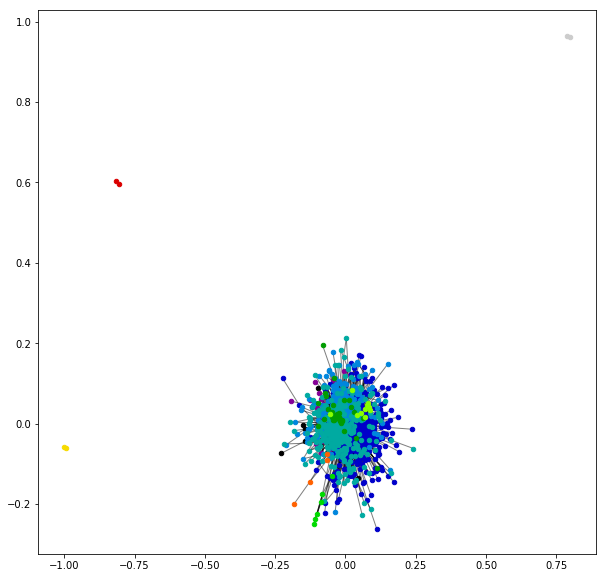

In [13]:
import networkx as nx

# Visualize components
plt.figure(figsize=(10, 10)) 
size = float(len(components))
pos = nx.spring_layout(analyzer.CG)
cmap = plt.cm.get_cmap('nipy_spectral', len(set(p.values())))
for i, com in enumerate(components):
    list_nodes = [node for node in p.keys() if p[node] == com]
    nx.draw_networkx_nodes(analyzer.CG, pos, list_nodes, node_size = 20, node_color = [cmap(i)])

nx.draw_networkx_edges(analyzer.CG, pos, alpha=0.5)
plt.show()

In [14]:
df_comp = pd.Series(p).reset_index().rename(columns={'index': 'pmid', 0: 'comp'})
df_all = pd.merge(df_all, df_comp, on='pmid')
df_all.head()

,pmid,title,year,1975,1976,1977,1979,1980,1981,1983,...,2012,2013,2014,2015,2016,2017,2018,2019,total,comp
0,1088947,Current theories of biological aging.,1975,2.0,2.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0,3
1,1691607,RNA and protein metabolism in the aging brain.,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,8.0,2
2,2526286,Possible organ and age-related epigenetic fact...,1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4
3,2643028,"DNA, mutations and aging.",1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,12.0,2
4,3310230,The inheritance of epigenetic defects.,1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,7.0,13.0,12.0,12.0,10.0,6.0,0.0,189.0,4


In [15]:
years = df_all.columns.values[3:-2].astype(int)
min_year, max_year = np.min(years), np.max(years)

In [16]:
n_comps = df_all['comp'].nunique()
ds = [None] * n_comps
layouts = [None] * n_comps
most_common = [None] * n_comps
for c in range(n_comps):
    ds[c] = build_data_source(df_all[df_all['comp'] == c])
    most_common[c] = dict(get_most_common_ngrams(df_all[df_all['comp'] == c]['title'].values))
    kwd = ', '.join([f'{k} ({v:.2f})' for k, v in most_common[c].items()])
    title = f'Subtopic #{c + 1}: {kwd}'
    layouts[c] = serve_scatter_article_layout(ds[c], title, year_range=[min_year, max_year])
    show(layouts[c])

## Top Cited Papers Overall

In [17]:
df_all = df_all.sort_values(by='total', ascending=False)

In [18]:
THRESHOLD = 0.1 # 10 %

In [19]:
ds_top = build_data_source(df_all.iloc[:round(len(analyzer.cit_df) * THRESHOLD), :])
layout_top = serve_scatter_article_layout(ds_top, 'Top cited papers', year_range=[min_year, max_year])
show(layout_top)

## Top Cited Papers for Each Year

In [20]:
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap

max_gain_data = []
cols = df_all.columns[3:-2]
for i in range(len(cols)):
    max_gain = df_all[cols[i]].astype(int).max()
    if max_gain > 0:
        sel = df_all[df_all[cols[i]] == max_gain]
        max_gain_data.append([cols[i], sel['pmid'].values[0], 
                              sel['title'].values[0], max_gain])
        
max_gain_df = pd.DataFrame(max_gain_data, columns=['year', 'pmid', 'title', 'count'])
max_gain_df.head(20)

ds_max = ColumnDataSource(data=dict(year=max_gain_df['year'], pmid=max_gain_df['pmid'].astype(str),
                                   title=max_gain_df['title'], count=max_gain_df['count']))
colors = factor_cmap('pmid', palette=Category10[10], factors=max_gain_df['pmid'].astype(str).unique())

year_range = [1985, 2019]
p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height=300, x_range=year_range, title='Max gain')
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Number of citations'
p.hover.tooltips = [
    ("PMID", '@pmid'),
    ("Title", '@title'),
    ("Year", '@year'),
    ("Cited by", '@count papers in @year')
]

p.vbar(x='year', width=0.8, top='count', fill_alpha=0.2, source=ds_max, fill_color=colors, line_color=colors)

show(p)

## Citation per Year Dynamics

In [21]:
p, h, panel = serve_citation_dynamics_layout()